# Kaggle KR 집값 예측하기

(this is late submission of [competition held by Kaggle-KR](https://www.kaggle.com/competitions/2019-2nd-ml-month-with-kakr))  
이 노트북은 Aiffel LMS EXP3 제출을 위해 작성되었습니다. 해당 노드의 3-9 그리드 서치 부분부터 거의 그대로 가져왔습니다. 그리드서치에 learning_rate를 추가한 것 이외에 바꾼 것은 없습니다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

data_dir = '../input/2019-2nd-ml-month-with-kakr/'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

In [2]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
dum_id=test['id']
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

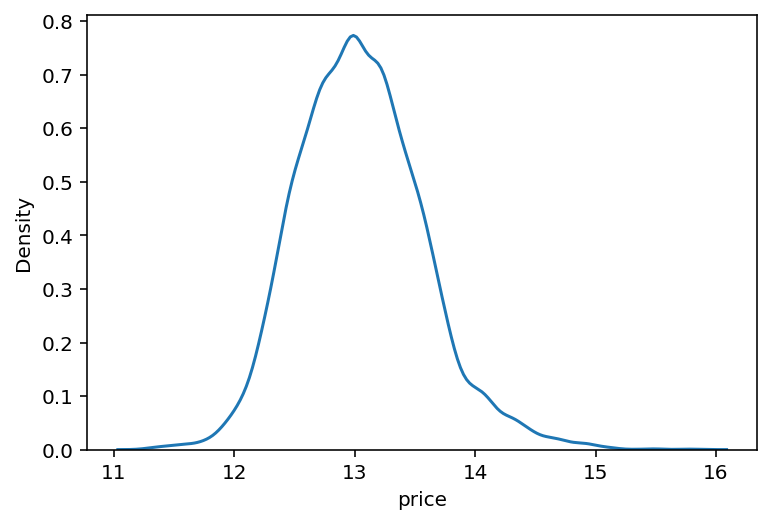

In [7]:
sns.kdeplot(y)
plt.show()

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [10]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [11]:
random_state=2020

In [12]:
xgboost = XGBRegressor(random_state=random_state)

In [13]:
model=xgboost
model_name = model.__class__.__name__

X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = rmse(y_test, y_pred)
print(score)

110318.66956616656


In [14]:

gboost = GradientBoostingRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df
        
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [15]:
from sklearn.model_selection import GridSearchCV


In [16]:

random_state=22
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                            scoring='neg_mean_squared_error', \
                            cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results=pd.DataFrame(params)
    results['score']=score
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results.sort_values('RMSLE')
    return results

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate': [0.001, 0.01,0.1],
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.001,1,50,-0.270001,0.519616
1,0.001,1,100,-0.262146,0.512002
2,0.001,10,50,-0.258047,0.507983
3,0.001,10,100,-0.239401,0.489286
4,0.010,1,50,-0.209696,0.457926
5,0.010,1,100,-0.166044,0.407484
6,0.010,10,50,-0.138643,0.372348
7,0.010,10,100,-0.081080,0.284745
8,0.100,1,50,-0.073394,0.270914
9,0.100,1,100,-0.055020,0.234564


In [17]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state, learning_rate=0.1)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([14.11202067, 12.71849347, 13.52092457, ..., 14.42214958,
       12.9088143 , 12.69894979])

In [18]:
print(len(prediction))
prediction = np.expm1(prediction)

6555


In [19]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.DataFrame()
submission['id']=dum_id
submission['price'] = prediction


# 에러
언젠가는 잘 된 것 같은데 뭐가 문제일까요? 이 노트북은 prediction 값의 숫자가 6555개인데 제출해야 할 것은 6468입니다. 심지어 id의 범위도 크게 다릅니다. 아쉽게도 문제를 수정할 시간이 없습니다.

In [20]:
submission_csv_path = 'submission.csv'
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

submission.csv
